In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
from collections import OrderedDict
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [2]:
#load google drive
from google.colab import drive

#authorization
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#data transform
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(128),
    transforms.ToTensor()
])

#load data
train_dir = '/content/drive/My Drive/CNN_Facial_Emotions/data/train_set/images'
train_files = os.listdir(train_dir)

from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
import torchvision

class FaceDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode = mode
        self.transform = transform
        if self.mode == 'train':
            if int(self.file_list[0][:4]) <= 112:
                self.label = 0
            elif int(self.file_list[0][:4]) >= 113 and int(self.file_list[0][:4]) <= 226:
                self.label = 1
            elif int(self.file_list[0][:4]) >= 227 and int(self.file_list[0][:4]) <= 361:
                self.label = 2
            elif int(self.file_list[0][:4]) >= 362 and int(self.file_list[0][:4]) <= 479:
                self.label = 3
            elif int(self.file_list[0][:4]) >= 480 and int(self.file_list[0][:4]) <= 588:
                self.label = 4
            elif int(self.file_list[0][:4]) >= 589 and int(self.file_list[0][:4]) <= 692:
                self.label = 5
            elif int(self.file_list[0][:4]) >= 693 and int(self.file_list[0][:4]) <= 806:
                self.label = 6
            elif int(self.file_list[0][:4]) >= 807 and int(self.file_list[0][:4]) <= 926:
                self.label = 7
            elif int(self.file_list[0][:4]) >= 927 and int(self.file_list[0][:4]) <= 1035:
                self.label = 8
            elif int(self.file_list[0][:4]) >= 1036 and int(self.file_list[0][:4]) <= 1142:
                self.label = 9
            elif int(self.file_list[0][:4]) >= 1143 and int(self.file_list[0][:4]) <= 1265:
                self.label = 10
            elif int(self.file_list[0][:4]) >= 1266 and int(self.file_list[0][:4]) <= 1377:
                self.label = 11
            elif int(self.file_list[0][:4]) >= 1378 and int(self.file_list[0][:4]) <= 1484:
                self.label = 12
            elif int(self.file_list[0][:4]) >= 1485 and int(self.file_list[0][:4]) <= 1606:
                self.label = 13
            elif int(self.file_list[0][:4]) >= 1607 and int(self.file_list[0][:4]) <= 1701:
                self.label = 14
            elif int(self.file_list[0][:4]) >= 1702 and int(self.file_list[0][:4]) <= 1814:
                self.label = 15
            elif int(self.file_list[0][:4]) >= 1815 and int(self.file_list[0][:4]) <= 1941:
                self.label = 16
            elif int(self.file_list[0][:4]) >= 1942 and int(self.file_list[0][:4]) <= 2047:
                self.label = 17
            elif int(self.file_list[0][:4]) >= 2048 and int(self.file_list[0][:4]) <= 2158:
                self.label = 18
            elif int(self.file_list[0][:4]) >= 2159 and int(self.file_list[0][:4]) <= 2273:
                self.label = 19
            elif int(self.file_list[0][:4]) >= 2274 and int(self.file_list[0][:4]) <= 2390:
                self.label = 20
            else:
                self.label = 21

    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]

#label classes
neutral_face = [tf for tf in train_files if int(tf[:4]) <= 112]
happy_face = [tf for tf in train_files if int(tf[:4]) >= 113 and int(tf[:4]) <= 226]
sad_face = [tf for tf in train_files if int(tf[:4]) >= 227 and int(tf[:4]) <= 361]
angry_face = [tf for tf in train_files if int(tf[:4]) >= 362 and int(tf[:4]) <= 479]
surprised_face = [tf for tf in train_files if int(tf[:4]) >= 480 and int(tf[:4]) <= 588]
disgusted_face = [tf for tf in train_files if int(tf[:4]) >= 589 and int(tf[:4]) <= 692]
fearful_face = [tf for tf in train_files if int(tf[:4]) >= 693 and int(tf[:4]) <= 806]
happysurprised_face = [tf for tf in train_files if int(tf[:4]) >= 807 and int(tf[:4]) <= 926]
happydisgusted_face = [tf for tf in train_files if int(tf[:4]) >= 927 and int(tf[:4]) <= 1035]
sadangry_face = [tf for tf in train_files if int(tf[:4]) >= 1036 and int(tf[:4]) <= 1142]
angrydisgusted_face = [tf for tf in train_files if int(tf[:4]) >= 1143 and int(tf[:4]) <= 1265]
appalled_face = [tf for tf in train_files if int(tf[:4]) >= 1266 and int(tf[:4]) <= 1377]
hatred_face = [tf for tf in train_files if int(tf[:4]) >= 1378 and int(tf[:4]) <= 1484]
angrysurprised_face = [tf for tf in train_files if int(tf[:4]) >= 1485 and int(tf[:4]) <= 1606]
sadsurprised_face = [tf for tf in train_files if int(tf[:4]) >= 1607 and int(tf[:4]) <= 1701]
disgustedsurprised_face = [tf for tf in train_files if int(tf[:4]) >= 1702 and int(tf[:4]) <= 1814]
fearfulsurprised_face = [tf for tf in train_files if int(tf[:4]) >= 1815 and int(tf[:4]) <= 1941]
awed_face = [tf for tf in train_files if int(tf[:4]) >= 1942 and int(tf[:4]) <= 2047]
sadfearful_face = [tf for tf in train_files if int(tf[:4]) >= 2048 and int(tf[:4]) <= 2158]
fearfuldisgusted_face = [tf for tf in train_files if int(tf[:4]) >= 2159 and int(tf[:4]) <= 2273]
fearfulangry_face = [tf for tf in train_files if int(tf[:4]) >= 2274 and int(tf[:4]) <= 2390]
saddisgusted_face = [tf for tf in train_files if int(tf[:4]) >= 2391 and int(tf[:4]) <= 2500]

neutral = FaceDataset(neutral_face, train_dir, transform = data_transform)
happy = FaceDataset(happy_face, train_dir, transform = data_transform)
sad = FaceDataset(sad_face, train_dir, transform = data_transform)
angry = FaceDataset(angry_face, train_dir, transform = data_transform)
surprised = FaceDataset(surprised_face, train_dir, transform = data_transform)
disgusted = FaceDataset(disgusted_face, train_dir, transform = data_transform)
fearful = FaceDataset(fearful_face, train_dir, transform = data_transform)
happysurprised = FaceDataset(happysurprised_face, train_dir, transform = data_transform)
happydisgusted = FaceDataset(happydisgusted_face, train_dir, transform = data_transform)
sadangry = FaceDataset(sadangry_face, train_dir, transform = data_transform)
angrydisgusted = FaceDataset(angrydisgusted_face, train_dir, transform = data_transform)
appalled = FaceDataset(appalled_face, train_dir, transform = data_transform)
hatred = FaceDataset(hatred_face, train_dir, transform = data_transform)
angrysurprised = FaceDataset(angrysurprised_face, train_dir, transform = data_transform)
sadsurprised = FaceDataset(sadsurprised_face, train_dir, transform = data_transform)
disgustedsurprised = FaceDataset(disgustedsurprised_face, train_dir, transform = data_transform)
fearfulsurprised = FaceDataset(fearfulsurprised_face, train_dir, transform = data_transform)
awed = FaceDataset(awed_face, train_dir, transform = data_transform)
sadfearful = FaceDataset(sadfearful_face, train_dir, transform = data_transform)
fearfuldisgusted = FaceDataset(fearfuldisgusted_face, train_dir, transform = data_transform)
fearfulangry = FaceDataset(fearfulangry_face, train_dir, transform = data_transform)
saddisgusted = FaceDataset(saddisgusted_face, train_dir, transform = data_transform)

#concat all
all_faces = ConcatDataset([neutral, happy, sad, angry, surprised, disgusted, fearful, happysurprised, 
              happydisgusted, sadangry, angrydisgusted, appalled, hatred, angrysurprised, 
              sadsurprised, disgustedsurprised, fearfulsurprised, awed, sadfearful, 
              fearfuldisgusted, fearfulangry, saddisgusted])

dataloader = DataLoader(all_faces, batch_size = 64, shuffle=True, num_workers=4)

In [5]:
samples, labels = iter(dataloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

KeyboardInterrupt: ignored

In [6]:
#download the pretrained model
import torchvision.models as models
model = models.resnet18(pretrained = True)
model

#switch device to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
# Freeze the parameters 
for param in model.parameters():
    param.requires_grad = False 

In [0]:
#Classifier architecture to put on top of resnet18
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,100)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(100,22)),
    ('output', nn.LogSoftmax(dim=1))
]))

model.fc = fc

In [11]:
#shifting model to gpu
model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch : 1/3.. Training Loss: 2.910561
Epoch : 2/3.. Training Loss: 2.762820
Epoch : 3/3.. Training Loss: 2.725792


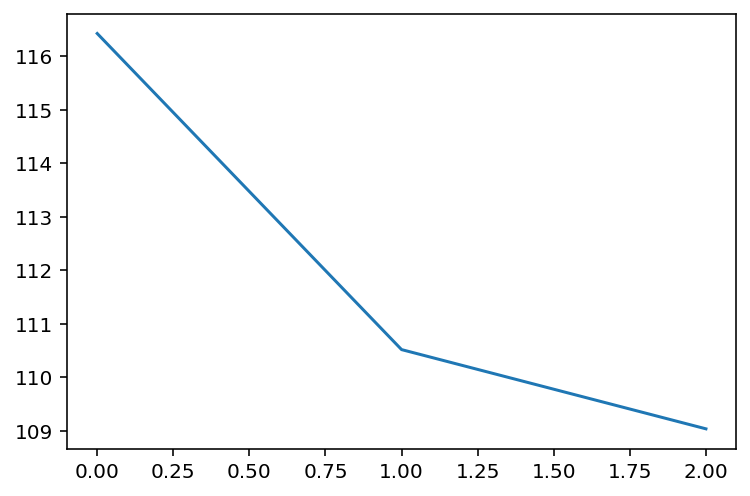

In [23]:
#function to train the model
def train(model, trainloader, criterion, optimizer, epochs = 5):
    train_loss = []
    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            inputs, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            img = model(inputs)
            
            loss = criterion(img, labels)
            running_loss += loss
            loss.backward()
            optimizer.step()
        print("Epoch : {}/{}..".format(e+1,epochs),
         "Training Loss: {:.6f}".format(running_loss/len(trainloader))) 
        train_loss.append(running_loss)
    plt.plot(train_loss,label="Training Loss")
    plt.show() 
    
    
    
epochs = 3
model.train()
optimizer = optim.SGD(model.fc.parameters(), lr=0.02)
criterion = nn.NLLLoss()    
train(model,dataloader,criterion, optimizer, epochs)            

In [0]:
#Save the model
filename_pth = 'resnet18_face.pth'
torch.save(model.state_dict(), filename_pth)

In [0]:
#test
test_dir = '/content/drive/My Drive/CNN_Facial_Emotions/data/train_set/images'
test_files = os.listdir(test_dir)

#Transform the test dataset
test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

testset = FaceDataset(test_files, test_dir, mode='test', transform = test_transform)
testloader = DataLoader(testset, batch_size = 64, shuffle=False, num_workers=4)

In [0]:
#predict
model.eval()
fn_list = []
pred_list = []
for x, fn in testloader:
    with torch.no_grad():
        x = x.to(device)
        output = model(x)
        pred = torch.argmax(output, dim=1)
        fn_list += [n[:-4] for n in fn]
        pred_list += [p.item() for p in pred]

submission = pd.DataFrame({"id":fn_list, "label":pred_list})
submission.to_csv('preds_resnet18.csv', index=False)

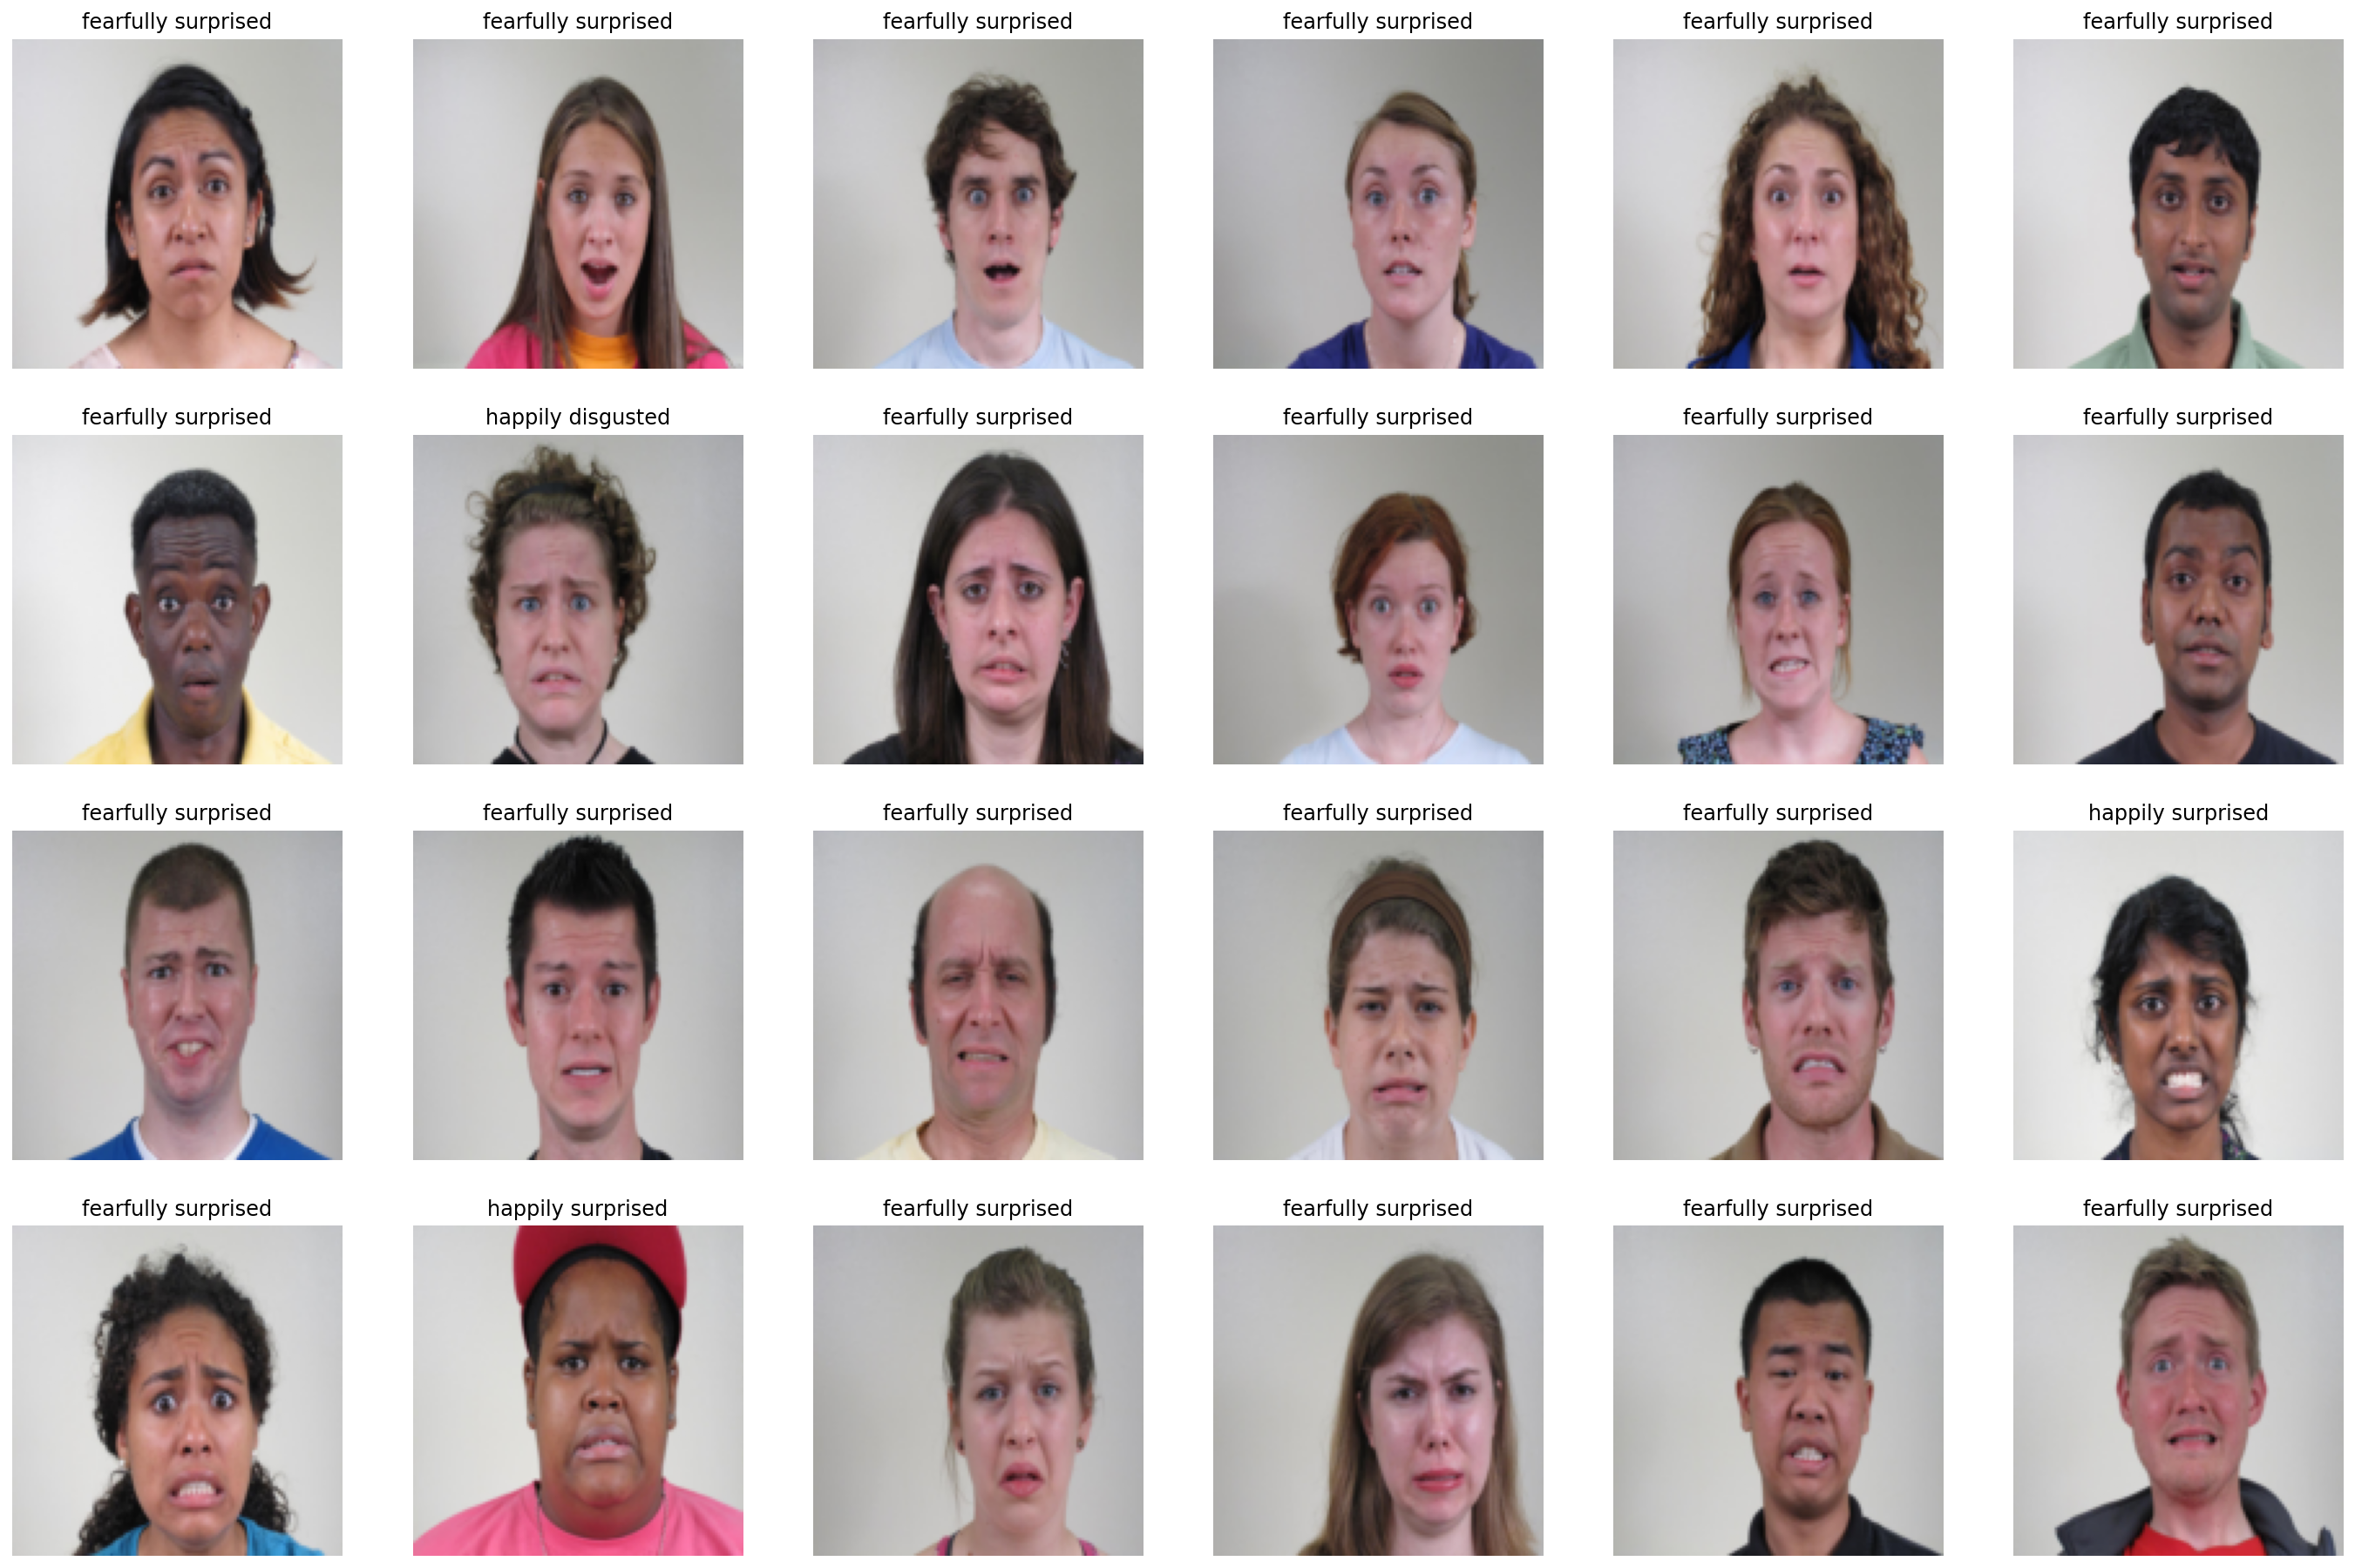

In [27]:
samples, _ = iter(testloader).next()
samples = samples.to(device)
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'neutral', 1:'happy', 2:'sad', 3:'angry', 4:'surprised', 5:'disgusted',
    6:'fearful', 7:'happily surprised', 8:'happily disgusted', 9:'sadly angry',
    10:'angrily disgusted', 11:'appalled', 12:'hatred', 13:'angrily surprised',
    14:'sadly surprised', 15:'disgustedly surprised', 16:'fearfully surprised',
    17:'awed', 18:'sadly fearful', 19:'fearfully disgusted',
    20:'fearfully angry', 21:'sadly disgusted'}
for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))